# document-clustering

Following along with Brandon Rose's document clustering tutorial on IMDB movie synopses.

https://github.com/brandomr/document_cluster/blob/master/cluster_analysis.ipynb

http://brandonrose.org/clustering

http://brandonrose.org/top100

In [125]:
%matplotlib inline

import bs4 as BeautifulSoup
import codecs
from collections import Counter
import matplotlib.pyplot as plt
import mpld3
import nltk
from nltk.stem.snowball import SnowballStemmer
import numpy as np
import os
import pandas as pd
import re
import requests
import seaborn as sns
from sklearn import feature_extraction
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Getting the IMDB movie synopsis data

In [126]:
# Get top 100 movie data from IMDB
r = requests.get('http://www.imdb.com/list/ls055592025/')
soup = BeautifulSoup.BeautifulSoup(r.text, 'html.parser')
list_items = soup.findAll('div', attrs={'class': 'list_item'})

URL_BASE = 'http://www.imdb.com'
SYNOPSIS_URL = URL_BASE + '{}' + 'synopsis'   # use with .format(url) for each movie

data = []
for item in list_items:
    number = item.find('div', attrs={'class': 'number'}).text
    info = item.find('div', attrs={'class': 'info'})
    title = info.find('b').text.split('\n')[0]
    year = info.find('span', attrs={'class': 'year_type'}).text
    description = item.find('div', attrs={'class': 'item_description'}).text
    description, length = description.split('. (')[0] + '.', description.split('. (')[1][:-2]
    partial_url = info.find('b').find('a')['href']
    full_url = URL_BASE + info.find('b').find('a')['href']
    synopsis_html = requests.get(SYNOPSIS_URL.format(partial_url)).text
    synopsis_soup = BeautifulSoup.BeautifulSoup(synopsis_html)
    synopsis = synopsis_soup.find('div', attrs={'id': 'swiki_body'}).text.strip()
    data.append([number, title, year, description, length, partial_url, full_url, synopsis])

In [127]:
titles = [movie[1] for movie in data]
synopses = [movie[7] for movie in data]

## Stopwords, stemming, and tokenizing
Stop words: common words that don't add to the meaning of the text

Stemming: shortening a word to it's root, so that words like "programming", "programmed", and "programs" are all the same.

Tokenizing: {{ fill info in here }}

In [128]:
# For this tutorial we'll use NLTK's stopwords, but sklearn also has a list of stopwords.
# (sklearn's list is actually longer, but includes some strange word choices like 'cry')
stopwords = nltk.corpus.stopwords.words('english')
stopwords_sklearn = feature_extraction.text.ENGLISH_STOP_WORDS

len(stopwords), len(stopwords_sklearn)

(153, 318)

In [129]:
# Load nltk's SnowballStemmer
stemmer = SnowballStemmer('english')

In [130]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_and_stem(text):
    return [stemmer.stem(t) for t in tokenize(text)]

In [131]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [132]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

## TF-IDF and Document Similarity

In [133]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                  min_df=0.2, stop_words='english',
                                  use_idf=True, tokenizer=tokenize_and_stem,
                                  ngram_range=(1,3))

In [134]:
tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

In [135]:
tfidf_matrix.shape

(100, 401)

C:\Users\steve\Anaconda2\lib\site-packages\seaborn\matrix.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
C:\Users\steve\Anaconda2\lib\site-packages\seaborn\matrix.py:142: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


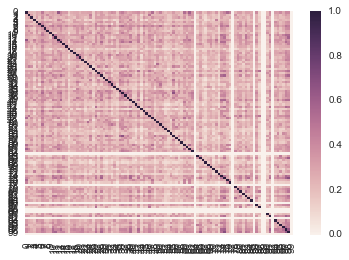

In [136]:
sns.heatmap((tfidf_matrix * tfidf_matrix.T).A)

In [137]:
terms = tfidf_vectorizer.get_feature_names()

In [138]:
dist = 1 - cosine_similarity(tfidf_matrix)

## K-means clustering

In [139]:
NUM_CLUSTERS = 5

km = KMeans(n_clusters=NUM_CLUSTERS)

km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [140]:
df = pd.DataFrame(data,
                     index=[clusters],
                     columns=['id',
                              'title',
                              'year',
                              'desc',
                              'length',
                              'partial_url',
                              'full_url',
                              'synopses'
                             ]
                    )
df['cluster'] = clusters

df

id                                              title    year  \
3     1.                                      The Godfather  (1972)   
1     2.                           The Shawshank Redemption  (1994)   
2     3.                                   Schindler's List  (1993)   
3     4.                                        Raging Bull  (1980)   
2     5.                                         Casablanca  (1942)   
3     6.                                       Citizen Kane  (1941)   
3     7.                                 Gone with the Wind  (1939)   
1     8.                                   The Wizard of Oz  (1939)   
2     9.                    One Flew Over the Cuckoo's Nest  (1975)   
2    10.                                 Lawrence of Arabia  (1962)   
1    11.                                            Vertigo  (1958)   
1    12.                                             Psycho  (1960)   
3    13.                             The Godfather: Part II  (1974)   
1    14.                                  On the Waterfront  (1954)   
1    15.                                       Sunset Blvd.  (1950)   
2    16.                                       Forrest Gump  (1994)   
3    17.                                 The Sound of Music  (1965)   
0    18.                                       12 Angry Men  (1957)   
1    19.                                    West Side Story  (1961)   
2    20.                 Star Wars: Episode IV - A New Hope  (1977)   
2    21.                              2001: A Space Odyssey  (1968)   
4    22.                         E.T. the Extra-Terrestrial  (1982)   
3    23.                           The Silence of the Lambs  (1991)   
1    24.                                          Chinatown  (1974)   
2    25.                       The Bridge on the River Kwai  (1957)   
0    26.                                Singin' in the Rain  (1952)   
4    27.                              It's a Wonderful Life  (1946)   
2    28.  Dr. Strangelove or: How I Learned to Stop Worr...  (1964)   
1    29.                                   Some Like It Hot  (1959)   
3    30.                                            Ben-Hur  (1959)   
..   ...                                                ...     ...   
0    71.                       Mr. Smith Goes to Washington  (1939)   
3    72.                                           Rain Man  (1988)   
0    73.                                         Annie Hall  (1977)   
1    74.                                            Tootsie  (1982)   
1    75.                                              Fargo  (1996)   
3    76.                                              Giant  (1956)   
3    77.                                The Grapes of Wrath  (1940)   
0    78.                                              Shane  (1953)   
4    79.                                     The Green Mile  (1999)   
2    80.                 Close Encounters of the Third Kind  (1977)   
1    81.                                          Nashville  (1975)   
3    82.                                            Network  (1976)   
1    83.                                       The Graduate  (1967)   
4    84.                                  American Graffiti  (1973)   
0    85.                                  Good Will Hunting  (1997)   
0    86.                                Terms of Endearment  (1983)   
4    87.                                       Pulp Fiction  (1994)   
4    88.                                  The African Queen  (1951)   
0    89.                                         Stagecoach  (1939)   
0    90.                               Mutiny on the Bounty  (1935)   
2    91.                                 The Great Dictator  (1940)   
1    92.                                 The Maltese Falcon  (1941)   
0    93.                                  Wuthering Heights  (1939)   
3    94.                                   Double Indemnity  (1944)   
1    95.                      

In [141]:
df['cluster'].value_counts()

3    27
2    25
1    23
4    13
0    12
Name: cluster, dtype: int64

In [142]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

"""for i in range(len(clusters)):
    print "Cluster {} words".format(i)
    
    for ind in order_centroids[i, :6]:
        part1 = vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0]
        part2 = part1.encode('utf-8', 'ignore')
        print '{}'.format(part2)"""

'for i in range(len(clusters)):\n    print "Cluster {} words".format(i)\n    \n    for ind in order_centroids[i, :6]:\n        part1 = vocab_frame.ix[terms[ind].split(\' \')].values.tolist()[0][0]\n        part2 = part1.encode(\'utf-8\', \'ignore\')\n        print \'{}\'.format(part2)'